In [ ]:
!pip install datasets

In [3]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import re
from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

--2021-10-26 11:58:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G  24.3MB/s    in 4m 19s  

2021-10-26 12:02:41 (24.3 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]



In [57]:
!tail -n 2 wiki.en.vec

style—but 0.070447 -0.14072 -0.65624 0.44562 0.093846 0.029631 -0.18981 -0.15442 0.043065 0.20402 -0.081675 0.43314 -0.32637 -0.18467 -0.30884 -0.11943 -0.18769 0.20119 -0.15296 0.16411 0.08494 -0.092707 0.04 0.16568 0.29459 0.028118 0.27135 0.1929 0.21838 0.095277 0.1308 0.22123 -0.49398 0.37017 -0.14654 0.053133 -0.16898 -0.11369 -0.23181 -0.12535 -0.14154 0.075662 0.082111 0.019291 0.12482 0.2302 -0.089153 0.14149 0.12761 -0.24876 0.077597 -0.34026 0.12535 0.20055 -0.18522 0.11459 0.21801 -0.097634 0.07866 0.17708 -0.057949 0.16689 -0.040789 0.22574 -0.029445 -0.063814 0.16282 0.7076 0.041795 0.059775 -0.072244 0.18128 -0.23501 0.2555 0.078896 0.16803 -0.069262 0.17466 0.044621 0.12005 -0.11696 -0.37913 0.20912 -0.017879 -0.14909 0.48079 0.079153 0.034718 -0.20746 0.088686 0.33523 0.016998 0.31303 -0.11954 0.2529 0.11243 0.23038 -0.060578 -0.10829 0.107 0.018652 -0.59998 0.1532 -0.035262 -0.20105 -0.39399 -0.33689 0.1384 -0.037944 -0.13595 0.07703 0.17178 -0.073602 0.10918 0.32407 -

In [7]:
def load_embeddings(path, num_tokens=100_000):
    """
    load_embeddings
    """
    token2index: Dict[str, int] = {
        "PAD":0,
        "UNK":1
    }
    with open(path, "r") as file:
        vocab_size, emb_dim = file.readline().strip().split()
        vocab_size, emb_dim = (int(vocab_size), int(emb_dim))
        num_tokens = min(num_tokens, vocab_size)
        embeddings = [
            np.zeros(emb_dim),
            np.ones(emb_dim)
        ]
        for line in file:
            parts = line.strip().split()
            token = " ".join(parts[:-emb_dim]).lower()
            embedding = np.array(list(map(float, parts[-emb_dim:])))
            if token in token2index:
                continue
            token2index[token] = len(token2index)
            embeddings.append(embedding)
            if len(token2index) == num_tokens:
                break
    embeddings_matrix: np.array = np.array(embeddings)
   
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

token2index, embeddings = load_embeddings("wiki.en.vec")

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [ ]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

In [58]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,
                 texts:List[str],
                 targets:List[int],                 
                 word2id:Dict[str, str]=token2index,
                 MAX_LEN:int=64):
        super().__init__()
        self.text = [torch.LongTensor([word2id[w] if w in word2id else 1 for w in self.preprocess(t)][:MAX_LEN]) for t in texts]
        self.text = torch.nn.utils.rnn.pad_sequence(self.text,
                                                    batch_first=True,
                                                    padding_value=word2id["PAD"])
        self.label = torch.LongTensor(targets)
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
    def __getitem__(self, item):
        ids = self.text[item]
        y = self.label[item]
        return ids, y
    
    def __len__(self):
        return self.length
    
    @staticmethod
    def preprocess(text):
        return re.findall("\w+", text)

In [59]:
new_train_dataset = Dataset(train_dataset["text"], train_dataset["label"])
new_valid_dataset = Dataset(valid_dataset["text"], valid_dataset["label"])
new_test_dataset = Dataset(test_dataset["text"], test_dataset["label"])

In [60]:
train_loader = DataLoader(new_train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(new_valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(new_test_dataset, batch_size=128, shuffle=False)

In [15]:
for x, y in train_loader:
    break

In [16]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Я выбрал метрику F1
Почему я выбрал эту метрику:  
Потому что она подходит для многоклассовой классификации и показывает эффективные результаты даже для задач с большим числом классов.

In [87]:
class DeepAverageNetwork(nn.Module):
    def __init__(self,
                 word2id:Dict[str, int] = token2index,
                 embedding_dim = 300,
                 output_dim:int = 3,
                 embeds:torch.Tensor = torch.Tensor(embeddings)):
        
        super().__init__()
        self.EMB_DIM = embedding_dim
        self.VOCAB_SIZE = len(word2id)
        self.OUT_DIM = output_dim

        self.embeds = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM).from_pretrained(embeds)
        self.linear1 = nn.Linear(self.EMB_DIM, self.EMB_DIM)
        self.linear2 = nn.Linear(self.EMB_DIM, self.EMB_DIM)
        self.hidden = nn.Linear(self.EMB_DIM, self.OUT_DIM)
        self.relu = nn.ReLU()
        # self.batchnorm = nn.BatchNorm1d(self.EMB_DIM)
        # self.dropout = nn.Dropout(0.05)
        self.act = nn.LogSoftmax(1)

    def forward(self, text):
        embedded = self.embeds(text)
        mean = torch.mean(embedded, dim=1).float()
        linear1 = self.relu(self.linear1(mean))
        linear2 = self.relu(self.linear2(linear1))
        hidden = self.hidden(linear2)
        return self.act(hidden)

In [88]:
model = DeepAverageNetwork(output_dim=3,
                           embeds=torch.Tensor(embeddings))

## Задайте функцию потерь и оптимизатор

In [89]:
# loss = nn.CrossEntropyLoss().to(device)
loss = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)

## Сделайте цикл обучения

In [65]:
def train(model:nn.Module,
          iterator:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:nn.modules.loss._Loss,
          print_every:int=1000):
    
    epoch_loss:List[float] = []
    epoch_f1:List[float] = []
    model.train()
    
    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = loss_fn(predictions, ys.to(device))
        
        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i + 1) % print_every:
            print(f"loss: {np.mean(epoch_loss)}; F1: {np.mean(epoch_f1)}")
    return np.mean(epoch_f1)
    
def evaluate(model:nn.Module,
             iterator:torch.utils.data.DataLoader,
             loss_fn:torch.nn.modules.loss._Loss):
    
    epoch_loss:list = []
    epoch_f1:list = []
        
    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            loss = loss_fn(predictions, ys.to(device))
            preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            y_true = ys.tolist()
            
            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
    return np.mean(epoch_f1)

In [90]:
f1s = []
f1s_eval = []

NUM_EPOCHS = 50  

for n_epoch in tqdm(range(NUM_EPOCHS)):
    print(f"\nEpoch #{str(n_epoch + 1)}:")
    f1s.append(train(model, train_loader, optimizer, loss))
    ev = evaluate(model, valid_loader, loss)
    print("\nMean F1 score: ", ev)
    f1s_eval.append(ev)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch #1:


  2%|▏         | 1/50 [00:03<02:51,  3.50s/it]


Mean F1 score:  0.4474609375

Epoch #2:


  4%|▍         | 2/50 [00:06<02:47,  3.49s/it]


Mean F1 score:  0.52978515625

Epoch #3:


  6%|▌         | 3/50 [00:11<02:57,  3.78s/it]


Mean F1 score:  0.51572265625

Epoch #4:


  8%|▊         | 4/50 [00:15<03:00,  3.93s/it]


Mean F1 score:  0.56845703125

Epoch #5:


 10%|█         | 5/50 [00:19<03:01,  4.02s/it]


Mean F1 score:  0.57255859375

Epoch #6:


 12%|█▏        | 6/50 [00:23<02:59,  4.08s/it]


Mean F1 score:  0.5509765625

Epoch #7:


 14%|█▍        | 7/50 [00:27<02:56,  4.11s/it]


Mean F1 score:  0.555078125

Epoch #8:


 16%|█▌        | 8/50 [00:32<02:54,  4.16s/it]


Mean F1 score:  0.5759765625

Epoch #9:


 18%|█▊        | 9/50 [00:36<02:52,  4.21s/it]


Mean F1 score:  0.5638671875

Epoch #10:


 20%|██        | 10/50 [00:40<02:48,  4.21s/it]


Mean F1 score:  0.58095703125

Epoch #11:


 22%|██▏       | 11/50 [00:44<02:43,  4.20s/it]


Mean F1 score:  0.5728515625

Epoch #12:


 24%|██▍       | 12/50 [00:49<02:39,  4.21s/it]


Mean F1 score:  0.5890625

Epoch #13:


 26%|██▌       | 13/50 [00:53<02:36,  4.23s/it]


Mean F1 score:  0.58974609375

Epoch #14:


 28%|██▊       | 14/50 [00:57<02:32,  4.24s/it]


Mean F1 score:  0.5828125

Epoch #15:


 30%|███       | 15/50 [01:01<02:28,  4.24s/it]


Mean F1 score:  0.58466796875

Epoch #16:


 32%|███▏      | 16/50 [01:06<02:24,  4.25s/it]


Mean F1 score:  0.586328125

Epoch #17:


 34%|███▍      | 17/50 [01:10<02:21,  4.28s/it]


Mean F1 score:  0.57861328125

Epoch #18:


 36%|███▌      | 18/50 [01:14<02:16,  4.26s/it]


Mean F1 score:  0.59755859375

Epoch #19:


 38%|███▊      | 19/50 [01:18<02:11,  4.24s/it]


Mean F1 score:  0.586328125

Epoch #20:


 40%|████      | 20/50 [01:23<02:07,  4.25s/it]


Mean F1 score:  0.58740234375

Epoch #21:


 42%|████▏     | 21/50 [01:27<02:04,  4.29s/it]


Mean F1 score:  0.5837890625

Epoch #22:


 44%|████▍     | 22/50 [01:31<01:59,  4.28s/it]


Mean F1 score:  0.5845703125

Epoch #23:


 46%|████▌     | 23/50 [01:35<01:54,  4.26s/it]


Mean F1 score:  0.59072265625

Epoch #24:


 48%|████▊     | 24/50 [01:40<01:50,  4.27s/it]


Mean F1 score:  0.5775390625

Epoch #25:


 50%|█████     | 25/50 [01:44<01:46,  4.25s/it]


Mean F1 score:  0.55537109375

Epoch #26:


 52%|█████▏    | 26/50 [01:48<01:41,  4.24s/it]


Mean F1 score:  0.59326171875

Epoch #27:


 54%|█████▍    | 27/50 [01:52<01:37,  4.23s/it]


Mean F1 score:  0.57490234375

Epoch #28:


 56%|█████▌    | 28/50 [01:57<01:33,  4.26s/it]


Mean F1 score:  0.59453125

Epoch #29:


 58%|█████▊    | 29/50 [02:01<01:28,  4.24s/it]


Mean F1 score:  0.584765625

Epoch #30:


 60%|██████    | 30/50 [02:05<01:24,  4.24s/it]


Mean F1 score:  0.5978515625

Epoch #31:


 62%|██████▏   | 31/50 [02:09<01:20,  4.24s/it]


Mean F1 score:  0.5939453125

Epoch #32:


 64%|██████▍   | 32/50 [02:14<01:16,  4.24s/it]


Mean F1 score:  0.5765625

Epoch #33:


 66%|██████▌   | 33/50 [02:18<01:12,  4.25s/it]


Mean F1 score:  0.59365234375

Epoch #34:


 68%|██████▊   | 34/50 [02:22<01:07,  4.22s/it]


Mean F1 score:  0.58583984375

Epoch #35:


 70%|███████   | 35/50 [02:26<01:04,  4.28s/it]


Mean F1 score:  0.5845703125

Epoch #36:


 72%|███████▏  | 36/50 [02:31<00:59,  4.27s/it]


Mean F1 score:  0.60205078125

Epoch #37:


 74%|███████▍  | 37/50 [02:35<00:55,  4.24s/it]


Mean F1 score:  0.598828125

Epoch #38:


 76%|███████▌  | 38/50 [02:39<00:50,  4.24s/it]


Mean F1 score:  0.58798828125

Epoch #39:


 78%|███████▊  | 39/50 [02:43<00:46,  4.24s/it]


Mean F1 score:  0.58828125

Epoch #40:


 80%|████████  | 40/50 [02:48<00:42,  4.24s/it]


Mean F1 score:  0.5841796875

Epoch #41:


 82%|████████▏ | 41/50 [02:52<00:38,  4.23s/it]


Mean F1 score:  0.58408203125

Epoch #42:


 84%|████████▍ | 42/50 [02:56<00:33,  4.24s/it]


Mean F1 score:  0.59873046875

Epoch #43:


 86%|████████▌ | 43/50 [03:00<00:29,  4.23s/it]


Mean F1 score:  0.5751953125

Epoch #44:


 88%|████████▊ | 44/50 [03:04<00:25,  4.23s/it]


Mean F1 score:  0.59609375

Epoch #45:


 90%|█████████ | 45/50 [03:09<00:21,  4.24s/it]


Mean F1 score:  0.60185546875

Epoch #46:


 92%|█████████▏| 46/50 [03:13<00:16,  4.24s/it]


Mean F1 score:  0.58369140625

Epoch #47:


 94%|█████████▍| 47/50 [03:17<00:12,  4.24s/it]


Mean F1 score:  0.563671875

Epoch #48:


 96%|█████████▌| 48/50 [03:21<00:08,  4.23s/it]


Mean F1 score:  0.5978515625

Epoch #49:


 98%|█████████▊| 49/50 [03:26<00:04,  4.25s/it]


Mean F1 score:  0.59345703125

Epoch #50:


100%|██████████| 50/50 [03:30<00:00,  4.21s/it]


Mean F1 score:  0.57333984375


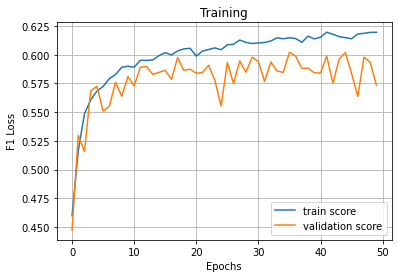

In [91]:
plt.figure()
plt.plot(f1s, label='train score')
plt.plot(f1s_eval, label='validation score')
plt.legend()
plt.grid()
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('F1 Loss');

In [102]:
def infer(model:nn.Module,
             iterator:torch.utils.data.DataLoader):
    
    answers:list = []
    true_answers:list = []
        
    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device))
            preds = predictions.detach().to("cpu").numpy().argmax(1).tolist()
            y_true = ys.tolist()
            answers.extend(preds)
            true_answers.extend(y_true)
    return answers, true_answers

In [103]:
y_pred, y_true = infer(model, test_loader)

In [112]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59      3972
           1       0.60      0.74      0.67      5937
           2       0.62      0.35      0.45      2375

    accuracy                           0.61     12284
   macro avg       0.61      0.55      0.57     12284
weighted avg       0.61      0.61      0.60     12284



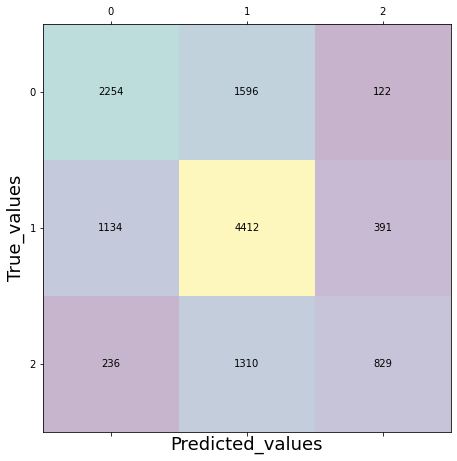

In [116]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
plt.xlabel('Predicted_values', fontsize=18)
plt.ylabel('True_values', fontsize=18)
plt.show()


Что в модели можно улучшить? Суммировать векторы по рассчитанному на корпусе tf-idf слов.

Все ли хорошо с моими данными? В неформальной речи из твиттера преобладают редкие слова, которые при малом размере словаря уходят в UNK. Классы несбалансированные.

Нужно ли поменять токенизацию или эмбеддинги? С векторами BERT и BERT-токенизацией возможно улучшение результатов.

Какие типичные ошибки у моей модели? 2 класс (negative) плохо определяется, часто ответ уходит в Neutral. Это может быть связано с малым размером словаря, который не вмещает ругательств.

Как я могу их исправить? Использовать BERT + фокус с усреднением по tf-idf. 